# 1. Data and model drift

Your team has built a number of models over the years and now there is concern about their
quality and possible drift. You will build a monitoring tool that captures model quality and
drift. Use all data prior to Dec-2013 (inclusively) to train a model and calculate the baseline
distributions you need for the first point of the dashboard based on this timeframe.

Then, you put this model in production and you calculate the scores for all clients after
Jan-2014 (inclusively). You are asked to capture the drift of the model scores and the top 5
features of the model once it goes in production on Jan-2014.

**Create a dashboard that includes the Jensen-Shannon divergence metric with the training
data as baseline distributions and monthly values after Jan-2014 for the following variables:**

1. the monthly scores
2. the monthly top 5 features of the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import distance
from sklearn.model_selection import GridSearchCV
from IPython import display as show

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(context='notebook', style='darkgrid', palette='brg', font='sans-serif', font_scale=1.5, color_codes=True)

### Import Monthly Excel files & Pre-process

In [2]:
mth_day_counts = pd.read_csv('mth_day_counts.csv')
days_since_last_txn = pd.read_csv('days_since_last_txn.csv')
mth_rolling_features = pd.read_csv('mth_rolling_features.csv')
Retail_Data_Response = pd.read_csv('Retail_Data_Response.csv')

In [3]:
monthly_features_output = mth_rolling_features.merge(mth_day_counts, how = 'inner',
                                                     on = ['CLNT_NO', 'ME_DT'])
monthly_features_output = monthly_features_output.merge(days_since_last_txn, how = 'inner',
                                                        on = ['CLNT_NO', 'ME_DT'])
monthly_features_output = monthly_features_output.merge(Retail_Data_Response, how = 'inner',
                                                        left_on = 'CLNT_NO',
                                                        right_on = 'customer_id')
monthly_features_output = monthly_features_output.drop(['customer_id'], axis = 1)
monthly_features_output = monthly_features_output.fillna(0)

monthly_features_output = monthly_features_output.sort_values(by = ['ME_DT'])

monthly_features_output.head(5)

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_amt_count,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,trans_count_Friday,trans_count_Monday,trans_count_Saturday,trans_count_Sunday,trans_count_Thursday,trans_count_Tuesday,trans_count_Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,-10,0
35626,CS1870,2011-05-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,-10,1
232744,CS6064,2011-05-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,-10,0
232697,CS6063,2011-05-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,-10,0
35673,CS1871,2011-05-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,-10,0


#### Filtering into 2 sets acourding to Date 

In [4]:
# Splitting the data
train = monthly_features_output.loc[monthly_features_output.ME_DT < '2014-01-31']
test = monthly_features_output.loc[monthly_features_output.ME_DT >= '2014-01-31']

X_train = train.drop(['response', 'CLNT_NO', 'ME_DT'], axis = 1)
y_train = train['response']
X_test = test.drop(['response', 'CLNT_NO'], axis = 1)
y_test = test['response']

# There's an unrequirement of Standardising the Data since we are working with Random Forest and is not distance based.

print('X_train shape =', X_train.shape)
print('y_train shape =', y_train.shape)
print('X_test shape =', X_test.shape)
print('y_test shape =', y_test.shape)
# show.display(train)
# show.display(test)

X_train shape = (220288, 28)
y_train shape = (220288,)
X_test shape = (103260, 29)
y_test shape = (103260,)


### What is the percentage of non-zero elements in X_train

In [5]:
print("The percentage of non-zero elements in X is: {:.2f} %".format(np.count_nonzero(X_train) / X_train.size * 100))

The percentage of non-zero elements in X is: 51.07 %


### Deriving the best Random Forest Model & Find Top 5 Features

In [6]:
# Best Random Forest Model ___________________ (VERY LONG PROCESSING TIME)

# rf = RandomForestClassifier(random_state=1148)
# params = {'n_estimators':[150, 200, 250], 
#           'max_features':["auto", "sqrt", "log2"], 
#           'max_depth':[10, 20, 30],
#           'min_samples_split':[10, 20, 30]}

# # Best Hyperparameters found using GridSearch CV

# grid = GridSearchCV(rf, param_grid = params, scoring = 'accuracy', cv = 5)
# grid.fit(X_train, y_train)
# grid.best_params_

In [7]:
# Training the best Model and fitting

rf = RandomForestClassifier(n_estimators = 250, max_features = 'auto', max_depth = 20, 
                            min_samples_split = 10, random_state = 1148)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='auto', min_samples_split=10,
                       n_estimators=250, random_state=1148)

### Compute the Importances

In [8]:
# Compute Feature Importance from the model
importances = rf.feature_importances_

# Converting it into a more presentable form
feature_importance = pd.DataFrame(importances, index = X_train.columns, columns = ['Feature Importance'])
feature_importance = feature_importance.sort_values(by = ['Feature Importance'], ascending = False)
top_5_features = feature_importance.index[0:5]
top_5_features

Index(['days_since_last_txn', 'amt_sum_12M', 'amt_mean_12M', 'amt_max_12M',
       'amt_max_6M'],
      dtype='object')

### Baseline Score and Clients scores after Jan-2014

In [9]:
baseline_score = rf.predict_proba(X_train)[:,1]
bin_edges = np.quantile(baseline_score, np.arange(0, 1.1, 0.1))
bin_edges[0] = 0
p = np.histogram(baseline_score, bin_edges)

### Monthly JS Divergence

In [10]:
month = X_test['ME_DT'].unique()
JS_monthly = []
for i in range(len(month)):
    test_set = X_test.loc[X_test['ME_DT'] == month[i]]
    test_set = test_set.drop(['ME_DT'],axis = 1)
    predict_test = rf.predict_proba(test_set)[:,1]
    q = np.histogram(predict_test,bin_edges)
    JS_monthly.append(distance.jensenshannon(p[0],q[0],2.0))

### Top 5 Feature Jensen-Shannon Divergence Metric

In [11]:
JS_feature = pd.DataFrame(index = top_5_features,columns = np.arange(0,15))
bin_edge = np.r_[-np.inf, bin_edges , np.inf]
for i in range(len(month)):
    for j in range(len(top_5_features)):
        test_set = X_test.loc[X_test['ME_DT'] == month[i]][top_5_features[j]]
        baseline_set = X_train[top_5_features[j]]
        target_score = test_set/test_set.max()
        baseline_score= baseline_set/baseline_set.max()
        p = np.histogram(baseline_score, bin_edge)
        q = np.histogram(target_score, bin_edge)
        JS_feature.at[top_5_features[j],i] = distance.jensenshannon(p[0], q[0], 2.0)

### Figure - Monthly JS divergence v/s Time

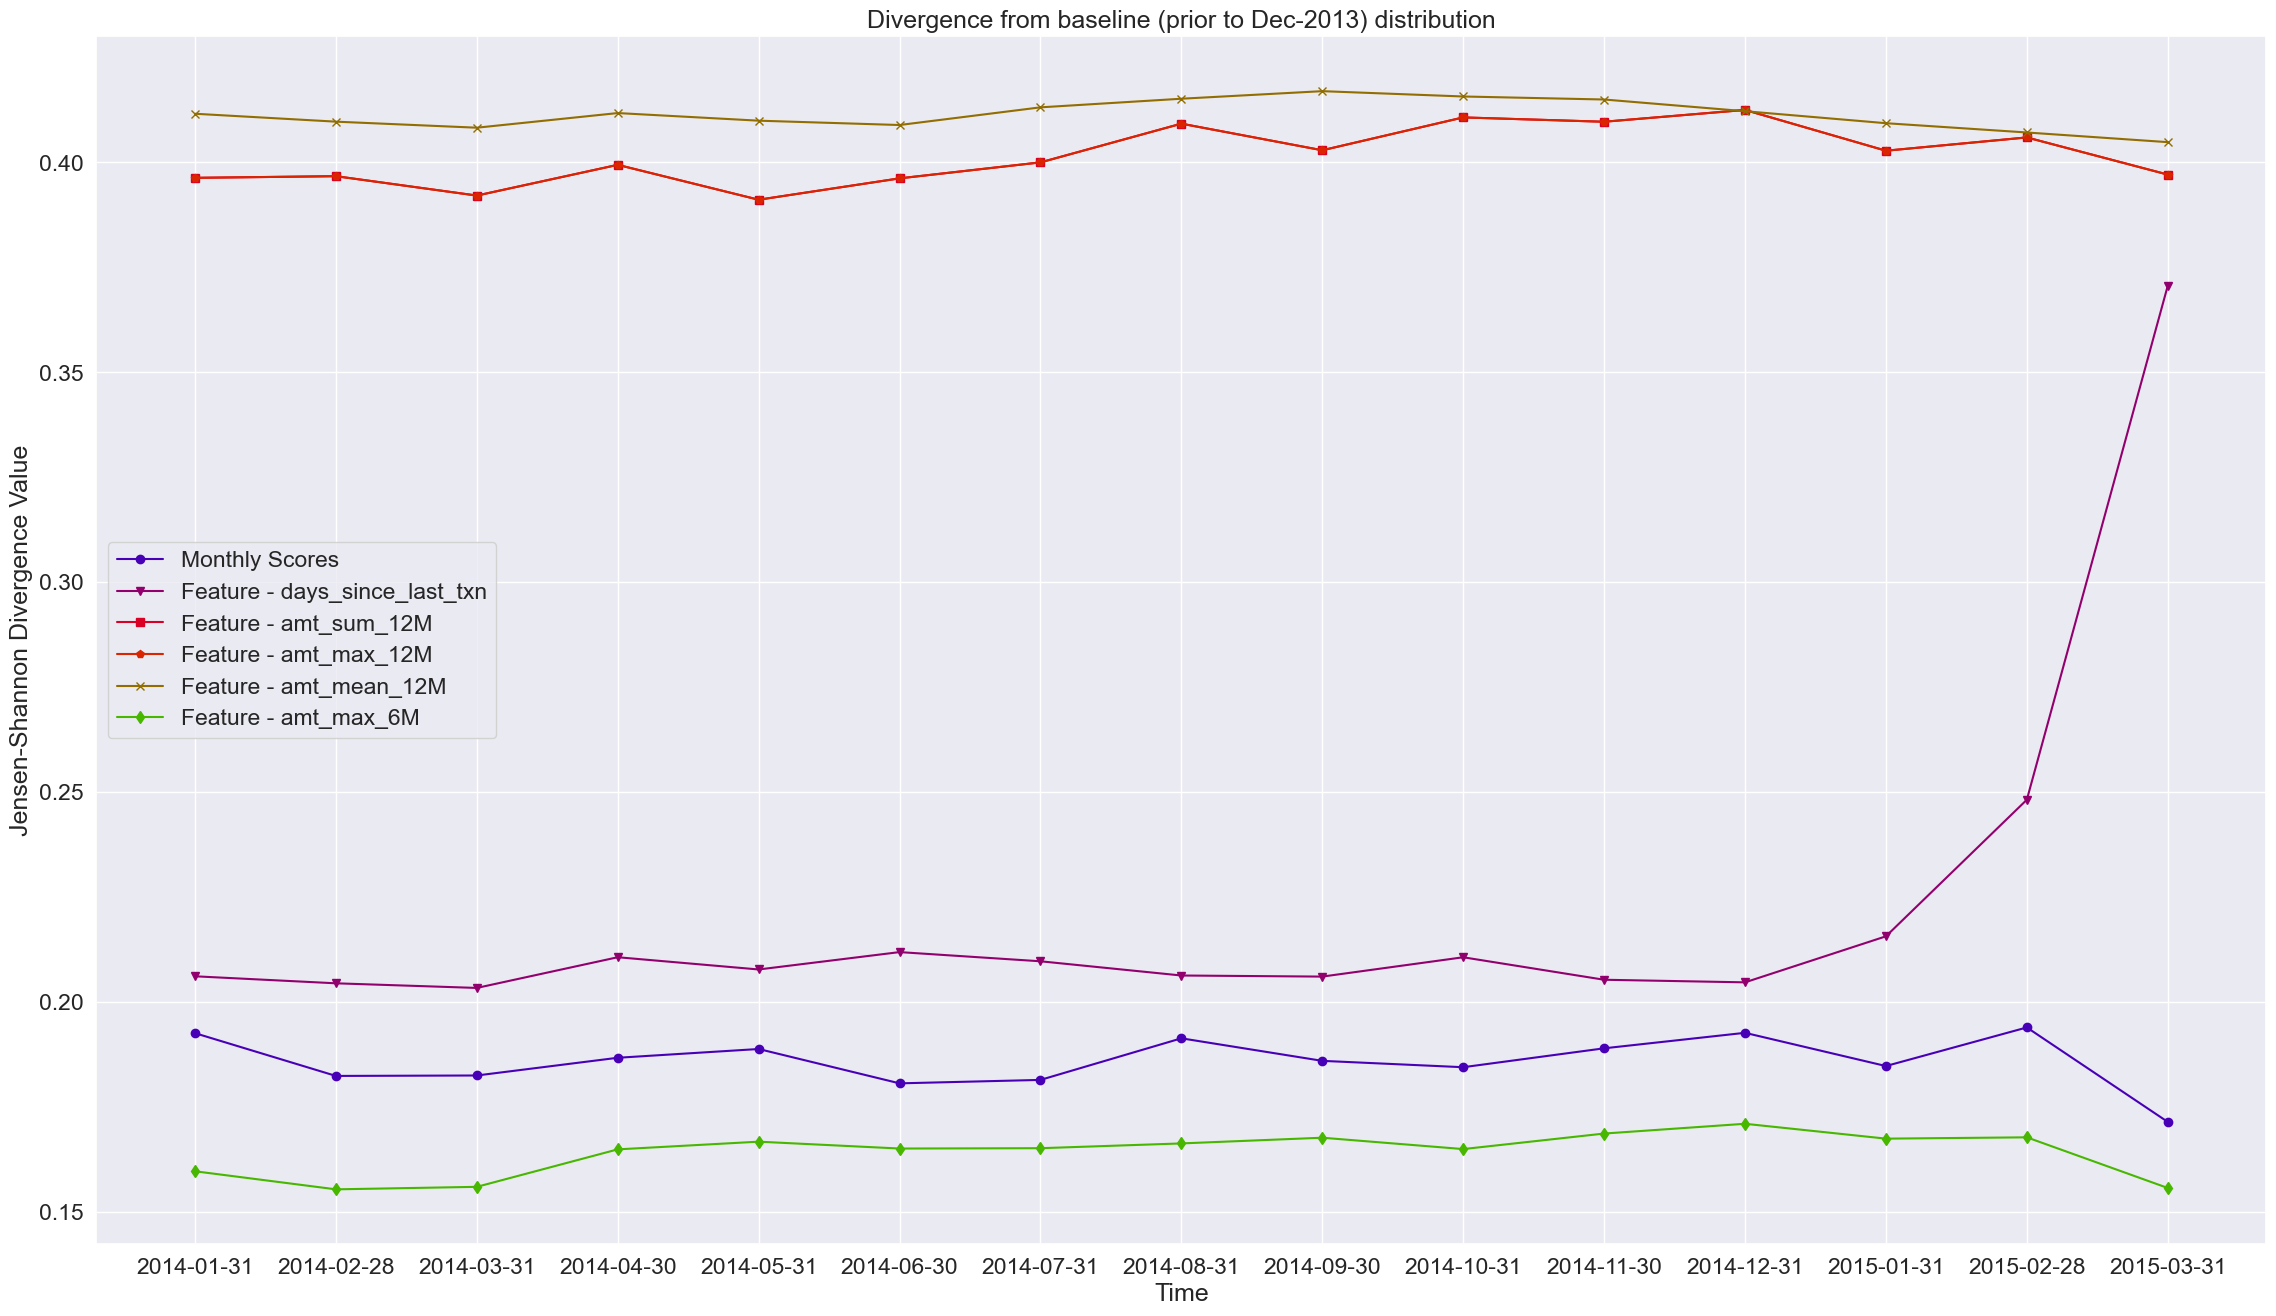

In [12]:
plt.figure(figsize = (28, 16), dpi = 100)
plt.plot(month, JS_monthly, '-o', label = 'Monthly Scores')
plt.plot(month, JS_feature.iloc[0,:], '-v', label = 'Feature - days_since_last_txn')
plt.plot(month, JS_feature.iloc[1,:], '-s', label = 'Feature - amt_sum_12M')
plt.plot(month, JS_feature.iloc[2,:], '-p', label = 'Feature - amt_max_12M')
plt.plot(month, JS_feature.iloc[3,:], '-x', label = 'Feature - amt_mean_12M')
plt.plot(month, JS_feature.iloc[4,:], '-d', label = 'Feature - amt_max_6M')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Jensen-Shannon Divergence Value')
plt.title('Divergence from baseline (prior to Dec-2013) distribution')
plt.show()

For the **Random Forest Model** with:
* n_estimators = 250, 
* max_features = 'auto'
* max_depth = 20 
* min_samples_split = 10

The `Top 5 features` with highest feature importance are 
            
* 'days_since_last_txn'
* 'amt_sum_12M' 
* 'amt_max_12M' 
* 'amt_mean_12M'
* 'amt_max_6M'. 

Also the Monthly Clients Scores are calculated by getting the probability of response = 1.  

From the `Jensen-Shannon Divergence v/s Time` graph, it can be seen that **Monthly JSD (Jensen-Shannon Divergence) Scores are around 0.2** and `less most majority cases`. It can be `concluded from this observation that the baseline distribution and the dates after Jan-14 are slightly different, but this difference is not very significant.`  

For `'days_since_last_txn'`, it can seen that **JSD scores are above 0.2 and for the last 3 months, it increases sharply to 0.375.** Thus the scores and distributions are very different for this feature.

For `'amt_sum_12M' & 'amt_mean_12M',` **JSD scores** are touching each other, `the later being always above 0.4 and the prior under 0.4 but above 0.2 and close, for the 1st 6 months.` Thus, it can be said that the distributions are very different from the rest.  

For `'amt_max_12M`, it has the highest **JSD scores** among all. These values are very far from the normal distribution around 0.2. The distributions of feature `amt_max_12M` are significantly different.  

Lastly `'amt_max_6M'`, the **JSD score** is the lowest, around the **0.15** and it stays that way for all months. For this feature, it can be said that there isn't much difference in the distributions.